In [286]:
import jax.numpy as jnp
from jax import jit, vmap, grad
from jax.lax import scan
from scipy.special import erfcx as sc_erfcx
from scipy.special import wofz as sc_wofz
from jax.scipy.special import erfc
import numpy as np

In [274]:
#def scan(f, init, xs, length=None):
#  if xs is None:
#    xs = [None] * length
#  carry = init
#  ys = []
#  for x in xs:
#    carry, y = f(carry, x)
#    ys.append(y)
#  return carry, np.stack(ys)

In [275]:
@jit
def erfcx(x):
    """erfcx (float) based on Shepherd and Laframboise (1981)
    
    Params:
        x: should be larger than -9.3
        
    Return:
        f: erfcx(x)
    """
    a=jnp.abs(x)
    q = (-a*(a-2.0)/(a+2.0)-2.0*((a-2.0)/(a+2.0)+1.0)+a)/(a+2.0) + (a-2.0)/(a+2.0)
    
    _CHEV_COEFS_=[5.92470169e-5,1.61224554e-4, -3.46481771e-4,-1.39681227e-3,1.20588380e-3, 8.69014394e-3,
     -8.01387429e-3,-5.42122945e-2,1.64048523e-1,-1.66031078e-1, -9.27637145e-2, 2.76978403e-1]
    chev=jnp.array(_CHEV_COEFS_)
    def fmascan(c,x):
        return c*q + x,None
    p,n = scan(fmascan, 0.0, chev)

    q = (p+1.0)/(1.0+2.0*a)
    d = (p+1.0)-q*(1.0+2.0*a)
    f = 0.5*d/(a+0.5) + q
    
    f=jnp.where(x>=0.0, f, 2.0*jnp.exp(a**2) - f) 
    
    return f

In [276]:
erfcx(-4.0),sc_erfcx(-4.0)

(DeviceArray(17772222., dtype=float32), 17772220.904016286)

In [277]:
%timeit erfcx(1.0)

255 µs ± 20.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [278]:
%timeit sc_erfcx(1.0)

451 ns ± 26.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [301]:
N=10000
#xv=jnp.linspace(-10.0,100.0,N)
#xvc=np.linspace(-10.0,100.0,N)

xv=jnp.logspace(-5,5,N)
xvc=np.logspace(-5,5,N)

In [284]:
verfcx=vmap(erfcx)
%timeit verfcx(xv)

375 µs ± 6.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [302]:
d=(verfcx(xv) - sc_erfcx(xvc))/ sc_erfcx(xvc)

(-3e-06, 3e-06)

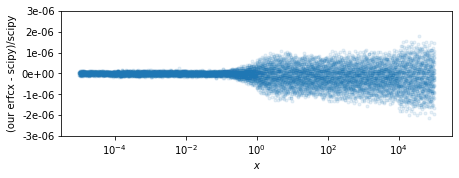

In [321]:
from matplotlib.ticker import FormatStrFormatter

fig=plt.figure(figsize=(7,2.3))
ax=fig.add_subplot(111)
ax.plot(xvc,d,".",alpha=0.1)
ax.yaxis.set_major_formatter(FormatStrFormatter("%1.e"))
plt.ylabel("(our erfcx - scipy)/scipy")
plt.xscale("log")
plt.xlabel("$x$")
plt.ylim(-3.e-6,3.e-6)
plt.savefig()

In [193]:
erfcx(-9.3)

DeviceArray(7.297299e+37, dtype=float32)

In [4]:
@jit
def perfcx(x):
    """erfcx (float) based on Shepherd and Laframboise (1981) for semi-positive x
    
    Params:
        x: should be larger than 0.0
        
    Return:
        f: erfcx(x)
    """
    q = (-x*(x-2.0)/(x+2.0)-2.0*((x-2.0)/(x+2.0)+1.0)+x)/(x+2.0) + (x-2.0)/(x+2.0)
    
    _CHEV_COEFS_=[5.92470169e-5,1.61224554e-4, -3.46481771e-4,-1.39681227e-3,1.20588380e-3, 8.69014394e-3,
     -8.01387429e-3,-5.42122945e-2,1.64048523e-1,-1.66031078e-1, -9.27637145e-2, 2.76978403e-1]
    chev=jnp.array(_CHEV_COEFS_)
    def fmascan(c,y):
        return c*q + y,None
    p,n = scan(fmascan, 0.0, chev)

    q = (p+1.0)/(1.0+2.0*x)
    d = (p+1.0)-q*(1.0+2.0*x)
    f = 0.5*d/(x+0.5) + q    
    return f

In [12]:
N=100000
xv=jnp.linspace(-10.0,100.0,N)
verfcx=vmap(erfcx)
%timeit verfcx(xv)

376 µs ± 5.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
vperfcx=(vmap(perfcx))
%timeit vperfcx(xv)

378 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
import matplotlib.pyplot as plt
xv=jnp.linspace(-10.0,10.0,N)

In [24]:
0.5*0.5

0.25

In [263]:
@jit
def rewofz(x,y):
    #a=0.5
    xy=x*y
    xyp=xy/jnp.pi
    exx=jnp.exp(-x*x)
    f=exx*erfcx(y)*jnp.cos(2.0*xy)+x*jnp.sin(xy)/jnp.pi*exx*jnp.sinc(xyp)
    
    nend=1000
    n=jnp.arange(1,nend+1,dtype=float)
    n2=n*n
    vec0=1.0/(0.25*n2+ y*y)
    vec1=jnp.exp(-(0.25*n2+x*x))
    vec2=jnp.exp(-(0.5*n+x)*(0.5*n+x))
    vec3=jnp.exp(-(0.5*n-x)*(0.5*n-x))
    Sigma1=jnp.dot(vec0,vec1)
    Sigma2=jnp.dot(vec0,vec2)
    Sigma3=jnp.dot(vec0,vec3)
    f = f + 1.0/jnp.pi*(-y*jnp.cos(2.0*xy)*Sigma1 + 0.5*y*Sigma2 + 0.5*y*Sigma3)
    return f

In [264]:
vrewofz=vmap(rewofz,(0,None),0)

In [238]:
# xmax=nend/2

In [270]:
rewofz(502.0,20)

DeviceArray(2.590563e-07, dtype=float32)

In [265]:

gvvrewofz=vmap(grad(rewofz,argnums=0),(0,None),0)


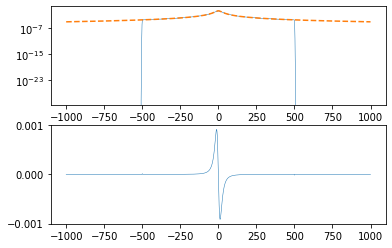

In [266]:

N=1000
xv=jnp.linspace(-1000,1000,N)
xvc=np.linspace(-1000,1000,N)


fig=plt.figure()
ax=fig.add_subplot(211)
ax.plot(xv,vrewofz(xv,20),lw=0.5)
ax.plot(xvc,sc_wofz(xvc+20*(1j)).real,ls="dashed")
plt.yscale("log")
ax=fig.add_subplot(212)
ax.plot(xv,gvvrewofz(xv,20),lw=0.5)


In [271]:
N=10000
xv=jnp.linspace(-10.0,10.0,N)
xvc=np.linspace(-10.0,10.0,N)
%timeit vrewofz(xv,1.0)
%timeit sc_wofz(xvc+1.0*(1j)).real

439 µs ± 15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.16 ms ± 6.36 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [272]:
N=10000
xv=jnp.linspace(-10.0,10.0,N)
xvc=np.linspace(-10.0,10.0,N)
%timeit gvvrewofz(xv,20)

3.68 ms ± 298 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


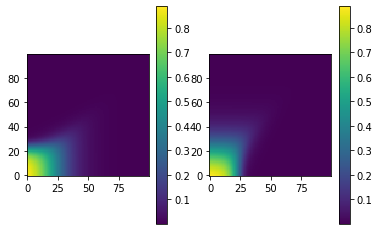

In [241]:
def H(a,x):
    z=x+(1j)*a
    w = sc_wofz(z)
    return w.real

vrewofz=vmap(rewofz,(0,None),0)
def fvrewofz(a):
    return vrewofz(xarrv,a)

vfvrewofz=vmap(fvrewofz,0,0)
np.shape(vfvrewofz(aarrv))
Na=100

xarrv=jnp.logspace(-1,3.3,Na)
xarr=xarrv[:,None]*jnp.ones((Na,Na))

aarrv=jnp.logspace(-1,3.3,Na)
aarr=aarrv[None,:]*jnp.ones((Na,Na))

fig=plt.figure()
ax=fig.add_subplot(121)
c=ax.imshow(H(aarr,xarr))
plt.colorbar(c)
plt.gca().invert_yaxis()
ax=fig.add_subplot(122)
c2=ax.imshow(vfvrewofz(aarrv))
plt.colorbar(c2)
plt.gca().invert_yaxis()

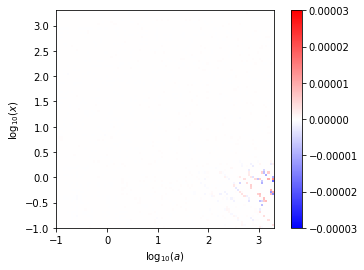

In [243]:
fig=plt.figure()
ax=fig.add_subplot(111)
#c=ax.imshow(np.log10(np.abs(H(aarr,xarr)-Tc(aarr,xarr))/H(aarr,xarr)),cmap="bwr",vmin=-1,vmax=1)
#c=ax.imshow(H(aarr,xarr))
#c=ax.imshow(vfvrewofz(aarrv))
c=ax.imshow((H(aarr,xarr)-vfvrewofz(aarrv).T)/H(aarr,xarr),vmin=-3.e-5,vmax=3.e-5,
            cmap="bwr",extent=([-1,3.3,3.3,-1]))
plt.ylabel("$\log_{10}(x)$")
plt.xlabel("$\log_{10}(a)$")
plt.colorbar(c)
plt.gca().invert_yaxis()